[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/ML-AI-for-the-Working-Analyst/blob/main/Semana5/SistemadeRecomendacion_SVD.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 5.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630169 sha256=eea5d9d537f39a043c0805f20977b7ce29112e9cfa769672f2d895e658c2dcc6
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


### Introducción

En este ejemplo utilizaremos los datos de la [competencia de Netflix](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data?select=combined_data_1.txt) en Kaggle. El objetivo de esta competencia era mejorar el algoritmo de recomendación 10%. Nosotros no seremos tan avariciosos. Por lo que los objetivos de esta clase son: 



*   Análisis exploratorio de matriz y por qué es dispersa.
*   Implementación de Singular Value Decomposition.
*   Implementación de un modelo de sistema de recomendación de filtro colaborativo.
*   Generar la predicción de recomendaciones con buen resultado y no.

In [ ]:
import math 
import re 

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from surprise import Reader, Dataset, SVD   # Simple Python RecommendatIon System Engine
from surprise.model_selection import cross_validate

En este caso cargar los datos nos llevará un rato por la gran cantidad de registros que tenemos. Sólo cargaremos un archivo, pero la competencia tiene un total de 3 archivos.

In [ ]:
# Recuerde, pueden conseguir la dirección del archivo en su Drive y copiarla en la dirección
df = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/combined_data_1.txt', 
                 names=['Client_Id', 'Rating', 'Date'], low_memory=True, nrows=12*(10**6)) 
#df2 = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/combined_data_2.txt', 
#                 names=['Client_Id', 'Rating', 'Date'], low_memory=True) 
#df3 = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/combined_data_3.txt', 
#                 names=['Client_Id', 'Rating', 'Date'], low_memory=True) 
#df4 = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/combined_data_4.txt', 
#                 names=['Client_Id', 'Rating', 'Date'], low_memory=True) 
#                 nrows=12*(10**6))

En este dataset tenemos sólo tres columnas 

In [ ]:
# df1.shape, df2.shape, df3.shape, df4.shape

In [ ]:
# df = pd.concat([df1, df2, df3, df4])

In [ ]:
df.head()

,Client_Id,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000000 entries, 0 to 11999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Client_Id  object 
 1   Rating     float64
 2   Date       object 
dtypes: float64(1), object(2)
memory usage: 274.7+ MB


In [ ]:
# Revisamos los nulos. 

df.isnull().sum()

Client_Id       0
Rating       2340
Date         2340
dtype: int64

En este caso los registros que tenemos con valores nulos corresponden al Id de las películas. Si observamos los registros nulos están ordenados del 1 al 2,340.

In [ ]:
df[df['Rating'].isnull()].shape

(2340, 3)

In [ ]:
df[df['Rating'].isnull()].head()

,Client_Id,Rating,Date
0,1:,NaN,NaN
548,2:,NaN,NaN
694,3:,NaN,NaN
2707,4:,NaN,NaN
2850,5:,NaN,NaN


In [ ]:
movies = df['Rating'].isnull().sum()
print(f'Este es el número de películas que tenemos en este archivo: {movies}')

Este es el número de películas que tenemos en este archivo: 2340


In [ ]:
reviews = df[df['Rating'].isnull()==False]['Client_Id'].count()
print(f'Este es el número de calificaciones: {reviews}')

Este es el número de calificaciones: 11997660


In [ ]:
users = df['Client_Id'].nunique() - movies
print(f'Esta es la cantidad de usuarios que tenemos: {users}')

Esta es la cantidad de usuarios que tenemos: 455716


En este caso no estaremos trabajando con las fechas. Por lo tanto haremos un subconjunto de nuestro DF original. 

In [ ]:
df_sub = df[['Client_Id', 'Rating']]

Ahora observemos como se distribuye la frecuencia para la columna de rating.

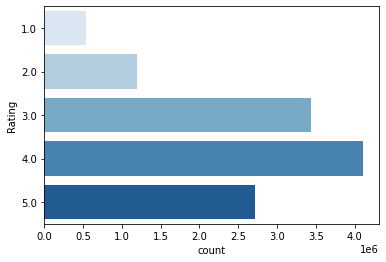

In [ ]:
sns.countplot(y=df_sub['Rating'], orient='v', palette='Blues');

In [ ]:
df_sub['Rating'].value_counts()/ df_sub['Rating'].count() * 100 

4.0    0.342391
3.0    0.286930
5.0    0.226388
2.0    0.099257
1.0    0.045034
Name: Rating, dtype: float64

La mayor parte de nuestros valores se distribuyen en los ratings de 3 y 4 estrellas. La mayoría de los rating son positivos.

### Hora de la limpieza

In [ ]:
## Diferencia entre "Series" y "DataFrame"
df_aux = df.iloc[:5,:]
df_aux

,Client_Id,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [ ]:
## Continuacion del anterior
# tipo DataFrame
df_aux[['Client_Id']]

,Client_Id
0,1:
1,1488844
2,822109
3,885013
4,30878


In [ ]:
# tipo Series
df_aux['Client_Id']

0         1:
1    1488844
2     822109
3     885013
4      30878
Name: Client_Id, dtype: object

En este caso los valores nulos que tenemos hacen referencia a **Id** de 'clientes' con rating vacíos. En realidad esta información es el **Id** de la película. Lo que debemos hacer ahora es quitar estos registros y añadir los **Id's** de película como una nueva columna. 

In [ ]:
# Generamos una serie con valores booleanos. Donde Verdadero será igual al lugar
# donde hay un Id de película.
pd.isnull(df_sub['Rating'][:100])

0      True
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: Rating, Length: 100, dtype: bool

In [ ]:
# Colocamos la serie como un DataFrame
df_null = pd.DataFrame(pd.isnull(df_sub['Rating']))
df_null.head()

,Rating
0,True
1,False
2,False
3,False
4,False


In [ ]:
# Obtenemos sólo los registros de películas junto con índice hasta donde llega 
# los rating para esa película.
df_null = df_null[df_null['Rating'] == True]
df_null.head()

,Rating
0,True
548,True
694,True
2707,True
2850,True


In [ ]:
# Colocamos el índice como columna para tener la ubicación para hasta donde repe-
# tir nuestros valores de Id para esa película.
df_null = df_null.reset_index()
df_null.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [ ]:
movie_id_array = [] # Generamos una lista vacía donde colocaremos el Id de la película las veces que se repita.
movie_id = 1 # Inicializamos un contador

# En esta celda para saber cómo hace el proceso imprimo los distintos pasos.
for i, j in zip(df_null['index'][1:3], df_null['index'][:-1]): # Iteramos sobre los valores de la columna 'index'
                                                               # empezando por el valor n+1 y en segundo lugar desde n hasta el penúltimo valor de la serie.
  print(i, j)
  temporary = np.full((1, i-j-1), fill_value=movie_id) # Creamos una matriz llena de valores con la forma de 1x(la diferencia del valor (n+1)-n-1).
                                                       # Esto nos da una matriz llena con el Id repetido el número de reviews para esa película.
  print(temporary)
  print(temporary.shape)
  movie_id_array = np.append(movie_id_array, temporary) # Lo añadimos a una lista. 
  movie_id += 1                                         # Aumentamos el Id para la siguiente película.
  print('---'*15)
  print(movie_id_array)
  print(movie_id)
  print('---'*30)
  print('---'*30)



548 0
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
movie_id_array = [] # Generamos una lista vacía donde colocaremos el Id de la película las veces que se repita.
movie_id = 1 # Inicializamos un contador

# En esta celda para saber cómo hace el proceso imprimo los distintos pasos.
for i, j in zip(df_null['index'][1:], df_null['index'][:-1]): # Iteramos sobre los valores de la columna 'index'
                                                               # empezando por el valor n+1 y en segundo lugar desde n hasta el penúltimo valor de la serie.
  temporary = np.full((1, i-j-1), fill_value=movie_id) # Creamos una matriz llena de valores con la forma de 1x(la diferencia del valor (n+1)-n-1).
                                                       # Esto nos da una matriz llena con el Id repetido el número de reviews para esa película.
  movie_id_array = np.append(movie_id_array, temporary) # Lo añadimos a una lista. 
  movie_id += 1                                         # Aumentamos el Id para la siguiente película.

In [ ]:
movie_id

2340

In [ ]:
# Generamos los Id's para la última película que no está contemplada en nuestro loop.
last_movie = np.full((1, len(df_sub) - df_null.iloc[-1, 0] - 1), movie_id)
movie_id_array = np.append(movie_id_array, last_movie)

In [ ]:
movie_id_array.shape # la cantidad de Id's corresponde con la cantidad de películas.

(11997660,)

Ahora para tener todo en orden es necesario que quitemos los registros nulos de nuestro df y añadamos los Id's que generamos.

In [ ]:
df_clean = df_sub[pd.notnull(df_sub['Rating'])]

In [ ]:
df_clean['Movie_Id'] = movie_id_array.astype('int16') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_clean['Client_Id'] = df_clean['Client_Id'].astype('int32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_clean.head()

,Client_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [ ]:
df_clean.tail()

,Client_Id,Rating,Movie_Id
11999995,2000580,2.0,2340
11999996,1809161,4.0,2340
11999997,1547886,2.0,2340
11999998,2905,2.0,2340
11999999,1876520,1.0,2340


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11997660 entries, 1 to 11999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Client_Id  int32  
 1   Rating     float64
 2   Movie_Id   int16  
dtypes: float64(1), int16(1), int32(1)
memory usage: 251.7 MB


In [ ]:
df_clean.isnull().sum().sum()

0



---



---



### Removiendo datos con poco valor informativo 

Nuestros datos se encuentran en el formato correcto. Sin embargo, existen muchos datos que no ayudan a nuestra predicción. ¿Por qué sucede esto? En esto momento no parece que tenemos valores nulos, sin embargo no todos los usuarios han calificado las 4,499 películas que tenemos. De aquí va a provenir nuestra matriz dispersa. 

Pero antes de pasar a la matriz intentemos reducir la cantidad de datos que tenemos removiendo dos casos de nuestro dataset:
1. Las películas que tiene pocas calificaciones. 
2. Usuarios que han calificado muy pocas películas.

In [ ]:
# Agregamos a nivel película para revisar el conteo y valor promedio para cada una.
movie_agg = df_clean.groupby('Movie_Id').agg({'Rating': ['count', 'mean']})
movie_agg

Rating          
          count      mean
Movie_Id                 
1           547  3.749543
2           145  3.558621
3          2012  3.641153
4           142  2.739437
5          1140  3.919298
...         ...       ...
2336         91  3.219780
2337       2534  2.426598
2338       3919  3.046696
2339       2418  3.468983
2340       3933  2.954488

[2340 rows x 2 columns]

In [ ]:
movie_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 1 to 2340
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Rating, count)  2340 non-null   int64  
 1   (Rating, mean)   2340 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.8 KB


In [ ]:
movie_agg.describe()

Rating             
               count         mean
count    2340.000000  2340.000000
mean     5127.205128     3.226168
std     15580.298039     0.525592
min        43.000000     1.287879
25%       192.000000     2.894154
50%       569.500000     3.244315
75%      2517.750000     3.612134
max    193941.000000     4.581296

Observamos el comportamiento de la distribución del conteo.

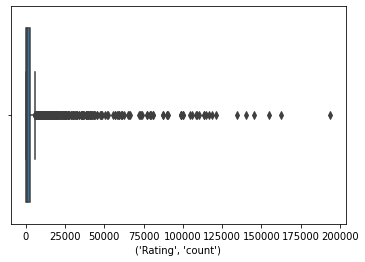

In [ ]:
sns.boxplot(x=movie_agg[('Rating', 'count')]);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2356: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


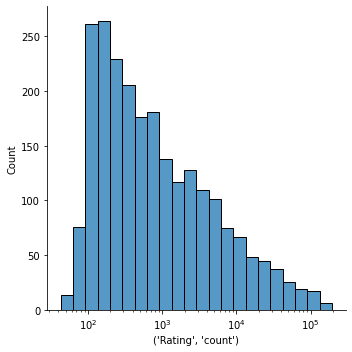

In [ ]:
sns.displot(data=movie_agg, x=('Rating', 'count'), log_scale=True);

Por el comportamiento de la distribución del conteo de nuestros ratings observamos que hay un número considerable de películas con un muy pocas calificaciones. Revisemos cuántas son.

In [ ]:
# Tomamos el valor del tercer cuartil.
movies_low_rating = movie_agg[('Rating', 'count')].quantile(0.75)
movies_low_rating

2517.75

In [ ]:
# Seleccionamos todas las películas que están por debajo del valor del cuartil
movies_to_drop = movie_agg[movie_agg[('Rating', 'count')] < movies_low_rating].index
movies_to_drop.shape

(1755,)

Ahora observemos el caso del conteo para los usuarios.

In [ ]:
user_agg = df_clean.groupby('Client_Id').agg({'Rating': ['count', 'mean']})['Rating']
user_agg.head()

,count,mean
Client_Id,,
6,76,3.289474
7,93,4.107527
8,11,3.909091
10,26,3.384615
25,2,3.500000


In [ ]:
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455716 entries, 6 to 2649429
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   count   455716 non-null  int64  
 1   mean    455716 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 10.4 MB


In [ ]:
user_agg.describe()

,count,mean
count,455716.000000,455716.000000
mean,26.327055,3.680549
std,38.074139,0.627960
min,1.000000,1.000000
25%,5.000000,3.333333
50%,13.000000,3.691489
75%,33.000000,4.000000
max,2327.000000,5.000000


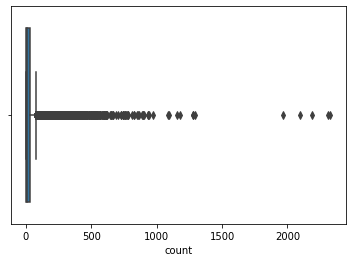

In [ ]:
sns.boxplot(x=user_agg['count']);

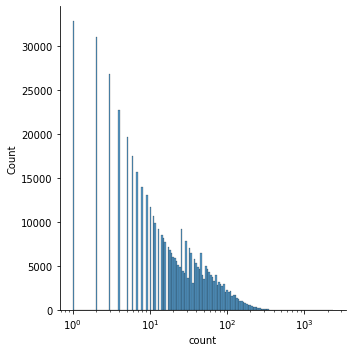

In [ ]:
sns.displot(data=user_agg, x='count', log_scale=True);

In [ ]:
user_low_rating = user_agg['count'].quantile(0.75)
user_low_rating

33.0

In [ ]:
users_to_drop = user_agg[user_agg['count'] < user_low_rating].index
users_to_drop.shape

(340160,)

Removamos las películas con bajo número de calificaciones tanto los usuarios con pocas películas calificadas.

In [ ]:
df_trim = df_clean[~df_clean['Movie_Id'].isin(movies_to_drop)]

In [ ]:
df_clean.shape, df_trim.shape

((11997660, 3), (11000284, 3))

In [ ]:
df_trim = df_clean[~df_clean['Client_Id'].isin(users_to_drop)]

In [ ]:
df_clean.shape, df_trim.shape

((11997660, 3), (8447711, 3))

In [ ]:
df_trim.shape[0] / df_clean.shape[0]

0.7041132187443218

Eliminamos el 30% de nuestros datos. 

### Convirtiendo a matriz dispersa o generando nuestra tabla Usuario-Item

In [ ]:
a = df_trim.copy()
a['Movie_Id'].value_counts().sort_index().index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340],
           dtype='int64', length=2340)

In [ ]:
movies_to_drop

Int64Index([   1,    2,    3,    4,    5,    6,    7,    9,   10,   11,
            ...
            2324, 2325, 2327, 2328, 2330, 2333, 2334, 2335, 2336, 2339],
           dtype='int64', name='Movie_Id', length=1755)

In [ ]:
# Por limitantes de la ramm, no podemos crearlo, pero en local o usando otras herramientas, podrían 
%%time
pivot_user_item = df_trim.pivot(index='Client_Id', columns='Movie_Id', values='Rating').fillna(0)

CPU times: user 12.7 s, sys: 5.02 s, total: 17.7 s
Wall time: 18 s


In [ ]:
pivot_user_item.head()

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,2331,2332,2333,2334,2335,2336,2337,2338,2339,2340
Client_Id,,,,,,,,,,,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Singular Value Decomposition (SVD)

La descomposición en valores singulares nos permite reducir las dimensiones de nuestra matriz a partir de su factorización. 

In [ ]:
# Utilizamos las clases y funciones que importamos del módulo surprise (Reader, Dataset, SVD)
reader = Reader()

data = Dataset.load_from_df(df_trim[['Client_Id', 'Movie_Id', 'Rating']][:100_000],
                            reader) # Es necesario pasar en este orden las columnas

svd = SVD() 
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3)

{'fit_time': (4.505069017410278, 4.50382399559021, 4.500276803970337),
 'test_mae': array([0.80853252, 0.80060369, 0.79968479]),
 'test_rmse': array([1.00733685, 0.99963834, 1.0083165 ]),
 'test_time': (0.4812004566192627, 0.3090541362762451, 0.2729661464691162)}

Ahora ya tenemos nuestra matriz factorizada y lista para generar recomendaciones. Pero antes de eso es necesario traer el nombre de nuestras películas. 

#### Cargando dataset con información de películas.

Hay que utilizar el mismo nombre para la columna del Id de película, esto nos servirá después para cruzar con nuestra recomendación.

In [ ]:
df_movies = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/movie_titles.csv', 
                        encoding='ISO-8859-1', names=['Movie_Id', 'Year', 'Title'])
df_movies.head()

,Movie_Id,Year,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
df_movies.set_index('Movie_Id', inplace=True) 

In [ ]:
df_movies.head()

,Year,Title
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Haciendo una recomendación

In [ ]:
# Obtengamos un usuario al azar
random_user_id = np.random.choice(df_trim['Client_Id'])
random_user_id

1811506

In [ ]:
# Veamos qué le ha gustado antes a este usuario (películas que calificó con 5 estrellas)

user = df_trim[(df_trim['Client_Id'] == random_user_id) & (df_trim['Rating'] == 5)].set_index('Movie_Id')
user_rated5_movies = user.join(df_movies)['Title']
user_rated5_movies 

Movie_Id
175                       Reservoir Dogs
199                      The Deer Hunter
571                      American Beauty
1466                     Midnight Cowboy
1476            Six Feet Under: Season 4
1571                         Poltergeist
1642    Casino: 10th Anniversary Edition
2178                                Lock
Name: Title, dtype: object

Recordemos que eliminamos de nuestra matriz películas que no tenían una cantidad considerable de calificaciones, así que debemos eliminarlas también de este listado de películas que utilizaremos para recomendar.

In [ ]:
movies_to_not_considered = movies_to_drop.to_list() + user_rated5_movies.index.to_list()

In [ ]:
create_recom = df_movies.copy()
create_recom = create_recom.reset_index()
create_list_of_possible_movies_to_recommend = create_recom[(~create_recom['Movie_Id'].isin(movies_to_not_considered))] 

create_list_of_possible_movies_to_recommend.shape

(16007, 3)



---



---



In [ ]:
%%time
data = Dataset.load_from_df(df_trim[['Client_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset() # cargamos todos nuestros datos en un objeto tipo trainset

svd.fit(trainset) # Ajustamos nuestros datos a la matriz que factorizamos. 

CPU times: user 9min 30s, sys: 5.58 s, total: 9min 36s
Wall time: 9min 37s




---



---



In [ ]:
# Obtenemos un Id de una película para estimar su posible valor de calificación.
random_movie_id = create_list_of_possible_movies_to_recommend.sample()
print(random_movie_id)
random_movie_id = random_movie_id.loc[:, 'Movie_Id'].values[0]

      Movie_Id    Year                           Title
4460      4461  2002.0  Godzilla Against Mechagodzilla


In [ ]:
# Hacemos la predicción y obtenemos el valor estimado de la calificación.
prediction = svd.predict(random_user_id, random_movie_id)
prediction

Prediction(uid=1811506, iid=4461, r_ui=None, est=3.4828824267464307, details={'was_impossible': False})

In [ ]:
def obtain_estimated_rating(id_user, id_movie):
  return lambda x: svd.predict()

In [ ]:
user_recommendations = create_list_of_possible_movies_to_recommend.copy()
user_recommendations['Estimated_Rating'] = user_recommendations['Movie_Id'].apply(lambda x: svd.predict(random_user_id, x).est)

In [ ]:
user_recommendations.head()

,Movie_Id,Year,Title,Estimated_Rating
7,8,2004.0,What the #$*! Do We Know!?,2.621559
15,16,1996.0,Screamers,3.198677
16,17,2005.0,7 Seconds,2.870332
17,18,1994.0,Immortal Beloved,3.903084
25,26,2004.0,Never Die Alone,2.913150


In [ ]:
user_recommendations.sort_values('Estimated_Rating', ascending=False)

,Movie_Id,Year,Title,Estimated_Rating
721,722,2003.0,The Wire: Season 1,4.722704
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,4.546062
2101,2102,1994.0,The Simpsons: Season 6,4.536535
2171,2172,1991.0,The Simpsons: Season 3,4.285511
2161,2162,2000.0,CSI: Season 1,4.281171
...,...,...,...,...
2108,2109,1982.0,Grease 2,2.078147
1606,1607,2004.0,Superbabies: Baby Geniuses 2,1.975852
1362,1363,1993.0,Leprechaun,1.895923
748,749,1990.0,Ernest Goes to Jail,1.849373
